---
# **Machine Learning - Pattern Recognition**
---
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_8g51Q_8Chc3UG7xb93uamcLCDTq6VdGEGGOVlKmeAw&s" align='right' height="160">
<img src="https://studyingreece.edu.gr/wp-content/uploads/2021/03/national-and-kapodistrian-university-of-athens-centered.jpg" align='right' height="160">


## [Assignment 2](https://eclass.uoa.gr/modules/work/?course=DI499&get=60316&file_type=1)

- **University:** National and Kapodistrian University of Athens
- **Department:** Informatics and Telecommunications
- **Name:** Pavlos Tomazos

In [3]:
# Pytorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

# Vizualization Libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Metrics Library
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import os
import librosa

import copy
import random
import numpy as np
import time

In [4]:
!pip install pytube pydub

from pytube import YouTube
from pydub import AudioSegment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exersice 1: Feedforward Neural Network

It will be useful for the exercises to create a custom dataset class called MusicSignals to load music signals represented either as mfccs or melgrams. In the class, the path where the 'music_genre_data_di' directory is stored must be specified.

In [6]:
class MusicSignals(Dataset):

    # Path where music_genre_data_di directory is stored
    path = '/content/drive/MyDrive/EKPA_University/Machine_Learning/'

    # Labels
    genre_labels = ['classical', 'hiphop', 'rock_metal_hardrock', 'blues']

    # Map the labels to numerical values
    labels_map = {'classical': 0, 'hiphop': 1, 'rock_metal_hardrock': 2, 'blues': 3}

    def __init__(self, dataset_type, representation):
        self.dataset_type = dataset_type
        self.representation = representation

        self.X = self.load_data('X')
        self.labels = [self.labels_map[label] for label in self.load_data('labels')]

        # Convert the data to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

    def load_data(self, data_file):
        return np.load(self.path + 'music_genre_data_di/' + self.dataset_type + '/' + self.representation + '/' + data_file + '.npy')

### Step 1: Load data (mfccs)

In this step, we load datasets train, val and test with music signals represented as Mel-frequency cepstral coefficients (MFCCs). Also, we load the data in Pytorch dataholders.

In [ ]:
# Mfccs data loading
train_dataset = MusicSignals('train', 'mfccs')
val_dataset = MusicSignals('val', 'mfccs')
test_dataset = MusicSignals('test', 'mfccs')

# Load data in Pytorch dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Step 2: Definition of Neural Network

We define a class of fully connected neural network which has an input dimension of 26 and consists of 3 layers with 128, 32, and 4 neurons respectively, where 4 is the number of classes to be predicted. At this point no activation functions will be used.

In [ ]:
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super(DenseNeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(26, 128)
        self.layer2 = nn.Linear(128, 32)
        self.layer3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

### Step 3: Define a training process  

We define a function for training the network. Given a number of epochs, an optimizer, a dataloader, a loss function, and a neural network, the function does the following:

1. Computes the output of the neural network given a batch of samples.
2. Computes and prints the loss.
3. Updates the weights of the network, and returns the neural network when the training is completed.


In [7]:
def train_network(neural_network, epochs, optimizer, dataloader, loss_function, device):
    neural_network = neural_network.to(device)
    loss_per_epoch = []

    start_time = time.time()
    for epoch in range(epochs):
        # Epoch loss
        epoch_loss = 0.0

        # Number of batches in the dataset
        total_samples = 0

        for i, batch in enumerate(dataloader):
            X, labels = batch
            X, labels = X.to(device), labels.to(device)

            # Prediction of Network
            pred = neural_network(X)

            # Computation of Loss
            loss = loss_function(pred, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = X.size(0)
            epoch_loss += loss.item() * batch_size
            total_samples += batch_size

        mean_loss = epoch_loss / total_samples  # Calculate mean loss for the epoch
        loss_per_epoch.append(mean_loss)
    end_time = time.time()

    return neural_network, loss_per_epoch, end_time - start_time

### Step 4: Definition of evaluation process  

We define a function for evaluation, which iterates through all batches of a dataloader using the model to compute predictions without updating the weights. Through the predictions, the function calculates and returns:

* Loss
* Macro-averaged F1 score
* Accuracy score
* Confusion Matrix



In [8]:
def evaluate_network(neural_network, dataloader, loss_function, device):
    neural_network.to(device)

    # Initialize variables for evaluation metrics
    total_loss = 0.0
    total_samples = 0
    predictions = []
    genre_labels = []

    # Set the model to evaluation mode
    neural_network.eval()

    with torch.no_grad():
        for batch in dataloader:
            # Get inputs and labels from batch
            X, labels = batch
            X, labels = X.to(device), labels.to(device)

            # Forward pass: compute the network's output
            pred = neural_network(X)

            # Compute the loss
            loss = loss_function(pred, labels)

            # Accumulate the total loss
            batch_size = X.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            # Get predictions
            _, predicted = torch.max(pred, 1)

            # Append predictions and labels to lists
            predictions.extend(predicted.tolist())
            genre_labels.extend(labels.tolist())

    # Compute evaluation metrics
    loss = total_loss / total_samples
    f1_macro = f1_score(genre_labels, predictions, average='macro')
    accuracy = accuracy_score(genre_labels, predictions)
    cm = confusion_matrix(genre_labels, predictions)

    return loss, f1_macro, accuracy, cm

### Step 5: Training the Network

Below the neural network is trained using:
* Optimizer: Stochastic Gradient Descent
* Learning rate: 0.002
* Loss function: Cross-Entropy Loss
* Number of epochs: 30

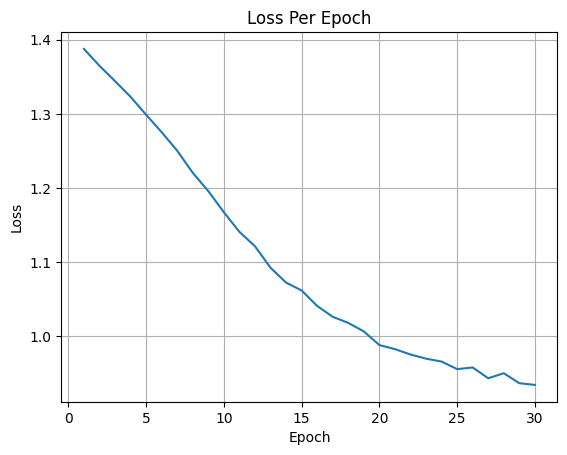

In [ ]:
# Initialize the neural network with deterministic weights
neural_network_1 = DenseNeuralNetwork()

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(neural_network_1.parameters(), lr = learning_rate)
epochs = 30

neural_network_1, mean_loss_per_epoch, cpu_training_time = train_network(neural_network_1, epochs, optimizer, train_dataloader, loss_function, 'cuda')

plt.plot(list(range(1, 31)), mean_loss_per_epoch)
plt.xlabel('Epoch')
plt.grid(True)
plt.ylabel('Loss')
plt.title('Loss Per Epoch')
plt.show()

It will be usefull for later tasks to define a function that displays the evaluation of a neural network model.

In [9]:
def display_evaluation(loss, f1_macro, accuracy, cm):
    print(f"Loss: {loss}")
    print(f"F1 macro averaged: {f1_macro}")
    print(f"Accuracy: {accuracy}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=train_dataset.genre_labels, yticklabels=train_dataset.genre_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

 Then, the evaluation function is used to calculate the performance of the trained model on the test set.

Loss: 0.9684084808064062
F1 macro averaged: 0.6260044297883346
Accuracy: 0.626453488372093


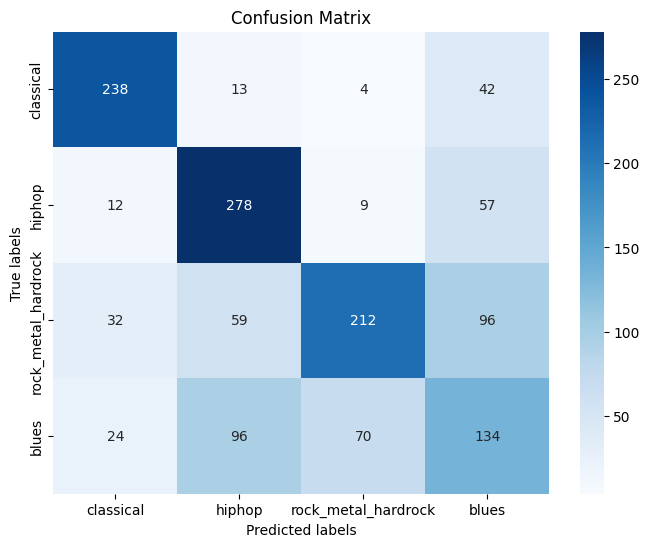

In [ ]:
loss, f1_macro, accuracy, cm = evaluate_network(neural_network_1, test_dataloader, loss_function, 'cpu')

display_evaluation(loss, f1_macro, accuracy, cm)

### Step 6: Training the network with GPU

Train Network with gpu and also compare the training time with the cpu.

Loss: 0.9430049157073331
F1 macro averaged: 0.6173513269477924
Accuracy: 0.6300872093023255


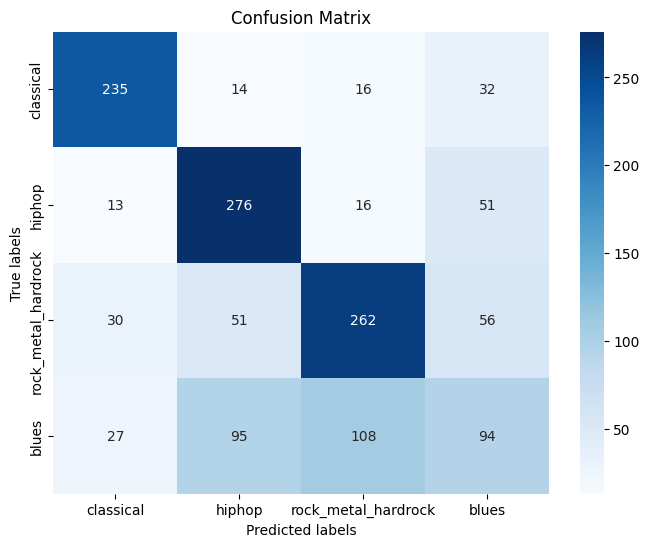

Time taken for training on CPU: 7.931410789489746 seconds
Time taken for training on GPU: 8.478649377822876 seconds


In [ ]:
# Initialize the neural network with deterministic weights
neural_network_2 = DenseNeuralNetwork()

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(neural_network_2.parameters(), lr = learning_rate)
epochs = 30

neural_network_2, mean_loss_per_epoch, gpu_training_time = train_network(neural_network_2, epochs, optimizer, train_dataloader, loss_function, 'cuda')
loss, f1_macro, accuracy, cm = evaluate_network(neural_network_2, test_dataloader, loss_function, 'cuda')

display_evaluation(loss, f1_macro, accuracy, cm)
print("Time taken for training on CPU:", cpu_training_time , "seconds")
print("Time taken for training on GPU:", gpu_training_time , "seconds")

### Step 7: Model Selection

During the training process (30 epochs), different snapshots of our neural network emerge, meaning models that have different weights. During the optimization process, we do not know which snapshot of our model has the best generalization ability. For this reason, we will use the validation set at the end of each epoch to evaluate the snapshots of the model.

In [10]:
def select_model(neural_network, epochs, optimizer, train_dataloader, val_dataloader, loss_function, device):
    best_f1_macro = 0
    best_model_state = copy.deepcopy(neural_network.state_dict())

    neural_network = neural_network.to(device)

    for epoch in range(epochs):
        neural_network.train()
        running_loss = 0.0
        total_samples = 0

        for batch in train_dataloader:
            X, labels = batch
            X, labels = X.to(device), labels.to(device)

            # Prediction of Network
            pred = neural_network(X)

            # Computation of Loss
            loss = loss_function(pred, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = X.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

        # Average training loss
        avg_train_loss = running_loss / total_samples

        avg_val_loss, f1, accuracy, cm = evaluate_network(neural_network, val_dataloader, loss_function, device)

        if f1 > best_f1_macro:
            best_f1_macro = f1
            best_model_state = copy.deepcopy(neural_network.state_dict())

    # Load the best model state
    neural_network.load_state_dict(best_model_state)

    return neural_network

Now let's check the results of the selected model

Loss: 0.9430049051379048
F1 macro averaged: 0.6173513269477924
Accuracy: 0.6300872093023255


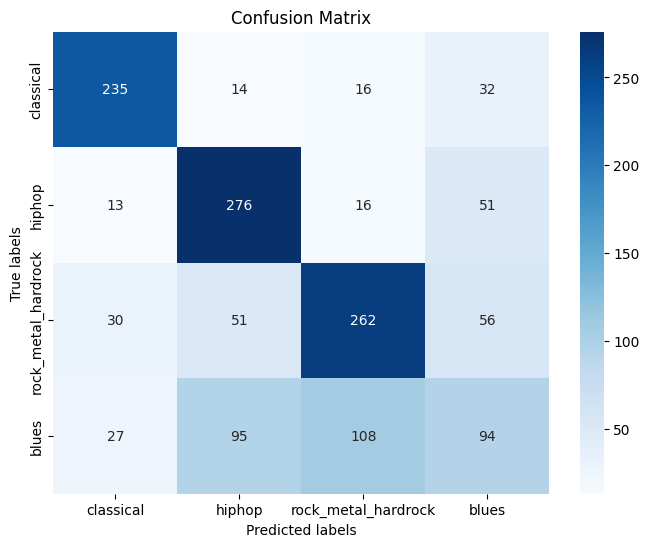

In [ ]:
neural_network_3 = DenseNeuralNetwork()

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(neural_network_3.parameters(), lr = learning_rate)
epochs = 30

neural_network_3 = select_model(neural_network_3, epochs, optimizer, train_dataloader, val_dataloader, loss_function, 'cpu')
loss, f1_macro, accuracy, cm = evaluate_network(neural_network_2, test_dataloader, loss_function, 'cpu')

display_evaluation(loss, f1_macro, accuracy, cm)

The results are slithly better than previously, where the selected model was just the last one and not choosed with a criterion of performance.

## Exersice 2: Convolutional Neural Network

### Step 1: Data Loading (spectrograms)  

Load data represented as mel-spectrograms.

In [8]:
# Melgrams data loading
train_dataset = MusicSignals('train', 'melgrams')
val_dataset = MusicSignals('val', 'melgrams')
test_dataset = MusicSignals('test', 'melgrams')

# Load data in Pytorch dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Visualize a random melgram from each class.

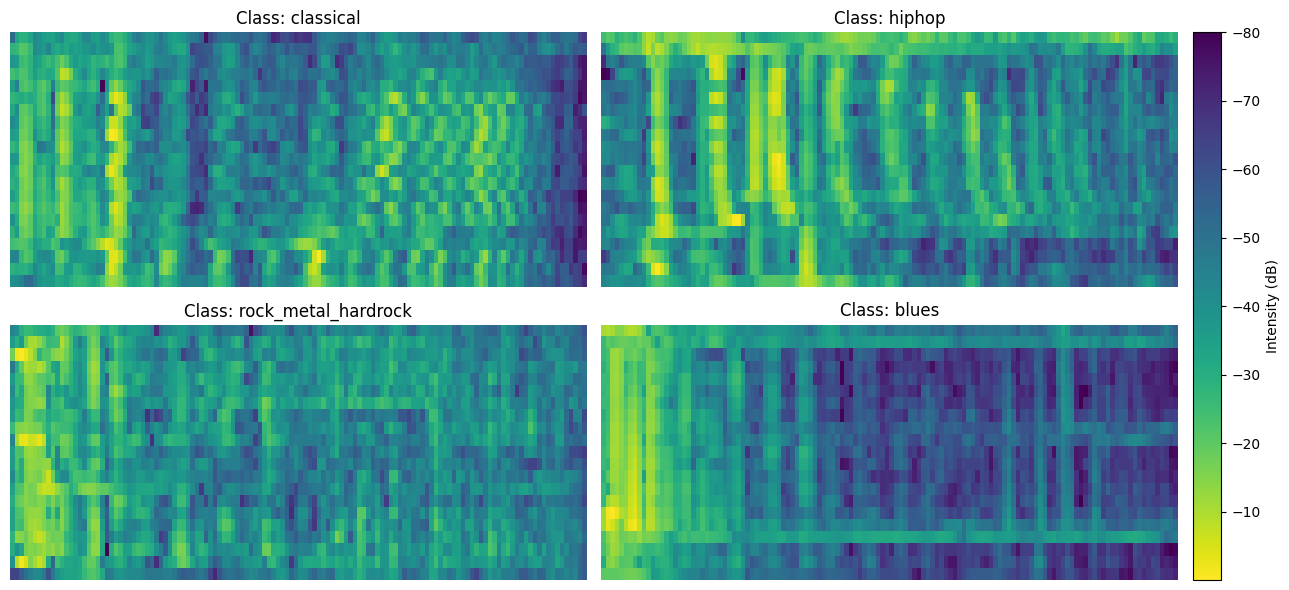

In [9]:
# Create a figure and grid layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.05])

# Plot a classical mel-spectrogram
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(train_dataset[1000][0], aspect='auto', origin='lower', cmap='viridis')
ax1.set_title('Class: classical')
ax1.axis('off')

# Plot a hiphop mel-spectrogram
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(train_dataset[2000][0], aspect='auto', origin='lower', cmap='viridis')
ax2.set_title('Class: hiphop')
ax2.axis('off')

# Plot a rock_metal_hardrock mel-spectrogram
ax3 = fig.add_subplot(gs[1, 0])
ax3.imshow(train_dataset[3000][0], aspect='auto', origin='lower', cmap='viridis')
ax3.set_title('Class: rock_metal_hardrock')
ax3.axis('off')

# Plot a blues mel-spectrogram
ax4 = fig.add_subplot(gs[1, 1])
ax4.imshow(train_dataset[0][0], aspect='auto', origin='lower', cmap='viridis')
ax4.set_title('Class: blues')
ax4.axis('off')

# Add a colorbar
cax = fig.add_subplot(gs[:, 2])
cbar = plt.colorbar(ax4.imshow(train_dataset[0][0], aspect='auto', origin='lower', cmap='viridis'), cax=cax, orientation='vertical')
cbar.set_label('Intensity (dB)')

# Reverse the colorbar ticks
cbar.ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Step 2: Definition of a Neural Network

Below is defined a CNN consisting of:

* Sequence of four convolutional layers, with kernel size 5, to achieve the following channel sequence: 1, 16, 32, 64, 128.

* A fully connected neural network with 4 layers and the number of neurons: x (dimension of the output of the convolutional network), 1024, 256, 32, out_dim.


After each convolution layer with kernel_size = 5 the height of the feature map changes like shown below:

$$ H' = \frac{H - kernel\_size + 2 \cdot  padding}{stride} + 1 = H - 5 + 1 = H - 4 $$

Similarly, $W' = W - 4  $

In [ ]:
class ConvolutionalNeuralNetwork1(nn.Module):
    def __init__(self, input_shape, out_dim):
        super(ConvolutionalNeuralNetwork1, self).__init__()

        height, width = input_shape

        # Convolutional layers and their output size
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        height, width = height - 4, width - 4
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        height, width = height - 4, width - 4
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        height, width = height - 4, width - 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5)
        height, width = height - 4, width - 4

        # Fully connected layers
        self.layer1 = nn.Linear(128 * height * width, 1024)
        self.layer2 = nn.Linear(1024, 256)
        self.layer3 = nn.Linear(256, 32)
        self.layer4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Add number of channels
        x = x.unsqueeze(1)

        # Apply convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

### Step 3: Training the network

The functions of training and evaluating a network remain exactly the same as they are generalized functions and they do not prevent as from using them for CNNs also.

By executing the training process using cpu, we observe that the training time for the CNN is significantly longer than that for the Dense Neural Network. Below, the training for one epoch gets much more than the training of a fully connected network for 30 epochs...

In [ ]:
cnn1 = ConvolutionalNeuralNetwork1((21, 128), 4)

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(cnn1.parameters(), lr = learning_rate)
epochs = 1

cnn1, _, cpu_training_time = train_network(cnn1, epochs, optimizer, train_dataloader, loss_function, 'cpu')

print("Time taken for training on CPU for only one epoch:", cpu_training_time, "seconds")

Time taken for training on CPU for only one epoch: 149.07997870445251 seconds


After training for one epoch using the GPU, we observe that the training loss evaluates to NaN, indicating it is undefined and cannot be computed. In later tasks, we will employ techniques to efficiently train the network and address this issue.

In [ ]:
cnn2 = ConvolutionalNeuralNetwork1((21, 128), 4)
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(cnn2.parameters(), lr = learning_rate)
epochs = 1

cnn2, loss, gpu_training_time = train_network(cnn2, epochs, optimizer, train_dataloader, loss_function, 'cuda')
print(loss)
print("Time taken for training on GPU:", gpu_training_time, "seconds")

[nan]
Time taken for training on GPU: 3.505270004272461 seconds


### Step 4: Pooling and padding

In this step we update the network architecture to include padding in the convolutional layers followed by max pooling.

After each convolution layer with kernel_size = 5 and padding = 2 the height of the feature map changes like shown below:

$$ H' = \frac{H - kernel\_size + 2 \cdot  padding}{stride} + 1 = H - 5 + 4 + 1 = H $$

As we can see the height does't change at all. After the pooling though:

$$ H'' = \frac{H' - kernel\_size}{stride} + 1 = \frac{H}{2} - 1 + 1 = \frac{H}{2}$$

Similarly, $W''= \frac{W}{2} $

In [ ]:
class ConvolutionalNeuralNetwork2(nn.Module):
    def __init__(self, input_shape, out_dim):
        super(ConvolutionalNeuralNetwork2, self).__init__()

        height, width = input_shape

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        # Fully connected layers
        self.layer1 = nn.Linear(128 * height * width, 1024)
        self.layer2 = nn.Linear(1024, 256)
        self.layer3 = nn.Linear(256, 32)
        self.layer4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Add number of channels
        x = x.unsqueeze(1)

        # Apply convolutional layers
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

In the following cell we train the CNN using the techniques of pooling and padding.

Padding helps maintain the size of the feature maps, keeping them the same as the original data. For example, using a kernel size of 5 and padding of 2 achieves this. Pooling then reduces the size of the data, retaining only the essential information, which makes the network faster and helps prevent overfitting.

Loss: 1.4331307644750395
F1 macro averaged: 0.7033153353045307
Accuracy: 0.7056686046511628


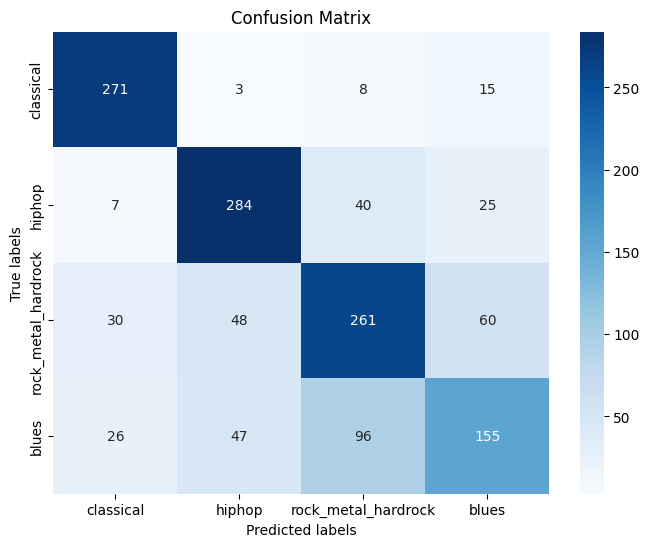

Time taken for training on GPU: 41.65771770477295 seconds


In [ ]:
cnn3 = ConvolutionalNeuralNetwork2((21, 128), 4)

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(cnn3.parameters(), lr = learning_rate)
epochs = 30

cnn3, _, gpu_training_time = train_network(cnn3, epochs, optimizer, train_dataloader, loss_function, 'cuda')

loss, f1_macro, accuracy, cm = evaluate_network(cnn3, test_dataloader, loss_function, 'cuda')

display_evaluation(loss, f1_macro, accuracy, cm)

print("Time taken for training on GPU:", gpu_training_time, "seconds")

### Step 5: Activation functions

The neural network we have constructed so far applies exclusively linear transformations to the data. In order for the network to learn more complex correlations in the data, we need to introduce non-linear activation functions.
For that reason we apply the ReLU activation function.

In [24]:
class ConvolutionalNeuralNetwork3(nn.Module):
    def __init__(self, input_shape, out_dim):
        super(ConvolutionalNeuralNetwork3, self).__init__()

        height, width = input_shape

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        # Fully connected layers
        self.fc1 = nn.Linear(128 * height * width, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):

        # Add channel dimension
        x = x.unsqueeze(1)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

Loss: 0.7495625150324994
F1 macro averaged: 0.7052663723031454
Accuracy: 0.7063953488372093


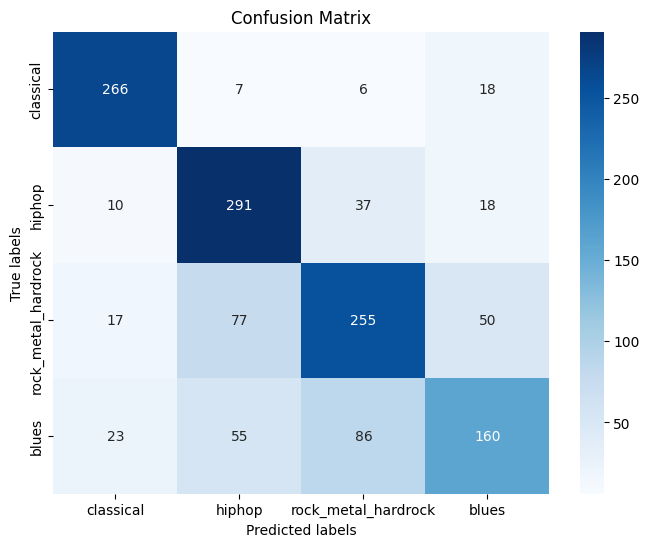

Time taken for training on GPU: 42.10507345199585 seconds


In [ ]:
cnn4 = ConvolutionalNeuralNetwork3((21, 128), 4)

loss_function = nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.SGD(cnn4.parameters(), lr = learning_rate)
epochs = 30

cnn4, _, gpu_training_time = train_network(cnn4, epochs, optimizer, train_dataloader, loss_function, 'cuda')

loss, f1_macro, accuracy, cm = evaluate_network(cnn4, test_dataloader, loss_function, 'cuda')

display_evaluation(loss, f1_macro, accuracy, cm)
print("Time taken for training on GPU:", gpu_training_time, "seconds")

## Exersice 3: Improving Performance

### Step 1: Reproducibility

In [29]:
# Set seed
seed = 74
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# For operations that are deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ensure reproducibility in DataLoader
g = torch.Generator()
g.manual_seed(seed)

# Load data in Pytorch dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, worker_init_fn=lambda _: np.random.seed(seed), generator = g)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, worker_init_fn=lambda _: np.random.seed(seed), generator = g)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, worker_init_fn=lambda _: np.random.seed(seed), generator = g)

Let's make sure that in every instance of a neural network the weights are the same.

In [30]:
torch.manual_seed(seed)
model1 = ConvolutionalNeuralNetwork3((21, 128), 4)
torch.manual_seed(seed)
model2 = ConvolutionalNeuralNetwork3((21, 128), 4)

# Function to compare model weights
def compare_model_weights(model1, model2):
    model1_state_dict = model1.state_dict()
    model2_state_dict = model2.state_dict()

    for key in model1_state_dict:
        if not torch.equal(model1_state_dict[key], model2_state_dict[key]):
            print(f"Weights differ for layer: {key}")
            return False
    return True

print(compare_model_weights(model1, model2))

True


### Step 2: Optimization Algorithms

We will train our model with different optimizers:

- Adadelta
- Adagrad
- Adam
- AdamW
- Adamax
- ASGD
- RMSprop
- Rprop
- SGD

In [32]:
# Optimizers dictionary
optimizers = {
    'Adadelta': optim.Adadelta,
    'Adagrad': optim.Adagrad,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'Adamax': optim.Adamax,
    'ASGD': optim.ASGD,
    'RMSprop': optim.RMSprop,
    'Rprop': optim.Rprop,
    'SGD': optim.SGD,
}

criterion = nn.CrossEntropyLoss()
learning_rate = 0.002
epochs = 30
results = {}

for opt_name, opt_class in optimizers.items():

    # Reinitialize model and optimizer
    torch.manual_seed(seed)
    model = ConvolutionalNeuralNetwork3((21, 128), 4).to('cuda')

    optimizer = opt_class(model.parameters(), lr=learning_rate)

    # Train and select the best model
    best_model = select_model(model, epochs, optimizer, train_dataloader, val_dataloader, criterion, 'cuda')

    # Evaluate the best model
    _, f1, accuracy, _ = evaluate_network(best_model, test_dataloader, criterion, 'cuda')

    # Store the results
    results[opt_name] = {'Accuracy': accuracy, 'F1 Score': f1}

In [33]:
import pandas as pd
from tabulate import tabulate

# Create a DataFrame
results_df = pd.DataFrame(results)

# Print DataFrame using tabulate
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid'))

╒══════════╤════════════╤═══════════╤═══════════╤══════════╤══════════╤══════════╤═══════════╤══════════╤══════════╕
│          │   Adadelta │   Adagrad │      Adam │    AdamW │   Adamax │     ASGD │   RMSprop │    Rprop │      SGD │
╞══════════╪════════════╪═══════════╪═══════════╪══════════╪══════════╪══════════╪═══════════╪══════════╪══════════╡
│ Accuracy │   0.558866 │  0.72311  │ 0.235465  │ 0.618459 │ 0.711483 │ 0.623547 │  0.704942 │ 0.595203 │ 0.649709 │
├──────────┼────────────┼───────────┼───────────┼──────────┼──────────┼──────────┼───────────┼──────────┼──────────┤
│ F1 Score │   0.555425 │  0.732388 │ 0.0952941 │ 0.616315 │ 0.721781 │ 0.635022 │  0.706608 │ 0.593788 │ 0.654262 │
╘══════════╧════════════╧═══════════╧═══════════╧══════════╧══════════╧══════════╧═══════════╧══════════╧══════════╛


As we can see, the optimizer that lead to the most accurate results is Adagrad. So that will be the optimizer we will select for our model.

### Step 3: Batch Normalization

We add after each convolutional layer a BatchNorm2d layer so it will be used before activation function.

In [34]:
class ConvolutionalNeuralNetwork4(nn.Module):
    def __init__(self, input_shape, out_dim):
        super(ConvolutionalNeuralNetwork4, self).__init__()

        height, width = input_shape

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm2d layer
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)  # BatchNorm2d layer
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)  # BatchNorm2d layer
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)  # BatchNorm2d layer
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        # Fully connected layers
        self.fc1 = nn.Linear(128 * height * width, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension

        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4(F.relu(self.conv4(x))))

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

### Step 4: Regularization

For this task we will do some experiments woth weight decay and dropout in the last definition of the convolutional neural network class (with batch normalization)

In [11]:
class ConvolutionalNeuralNetwork5(nn.Module):
    def __init__(self, input_shape, out_dim, dropout=0.0):
        super(ConvolutionalNeuralNetwork5, self).__init__()

        height, width = input_shape

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm2d layer
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)  # BatchNorm2d layer
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)  # BatchNorm2d layer
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)  # BatchNorm2d layer
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        height, width = height // 2, width // 2

        # Fully connected layers with dropout
        self.fc1 = nn.Sequential(
            nn.Linear(128 * height * width, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        # Add channel dimension
        x = x.unsqueeze(1)

        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4(F.relu(self.conv4(x))))

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

Below are the functions that will help as to make experiments with the weight decay and dropout techniques. The train function provides the training and validation loss so we can compare them and visualize their difference.

In [36]:
def train_model(model, epochs, optimizer, train_dataloader, val_dataloader, criterion, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        total_samples = 0

        for X, labels in train_dataloader:
            X, labels = X.to(device), labels.to(device)

            pred = model(X)
            loss = criterion(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = X.size(0)
            train_loss += loss.item() * batch_size
            total_samples += batch_size

        train_loss /= total_samples
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for X, labels in val_dataloader:
                X, labels = X.to(device), labels.to(device)

                pred = model(X)
                loss = criterion(pred, labels)

                batch_size = X.size(0)
                val_loss += loss.item() * batch_size
                total_samples += batch_size

        val_loss /= total_samples
        val_losses.append(val_loss)

    return train_losses, val_losses


def experiment(weight_decay, dropout, train_dataloader, val_dataloader, test_dataloader, device):
    # Define the model
    torch.manual_seed(seed)
    model = ConvolutionalNeuralNetwork5(input_shape=(21, 128), out_dim=4, dropout = dropout).to(device)

    # Define the optimizer
    optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=weight_decay)

    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Number of epochs
    epochs = 60

    # Train the model
    train_losses, val_losses = train_model(model, epochs, optimizer, train_dataloader, val_dataloader, criterion, device)

    # Evaluate the best model
    _, f1, accuracy, cm = evaluate_network(model, test_dataloader, criterion, device)

    return train_losses, val_losses, f1, accuracy, cm

In the following experiment for each weight decay value we plot validation and train loss to see their difference. As we can see the value that minimizes the differnece of train and validation losses is 0.06.


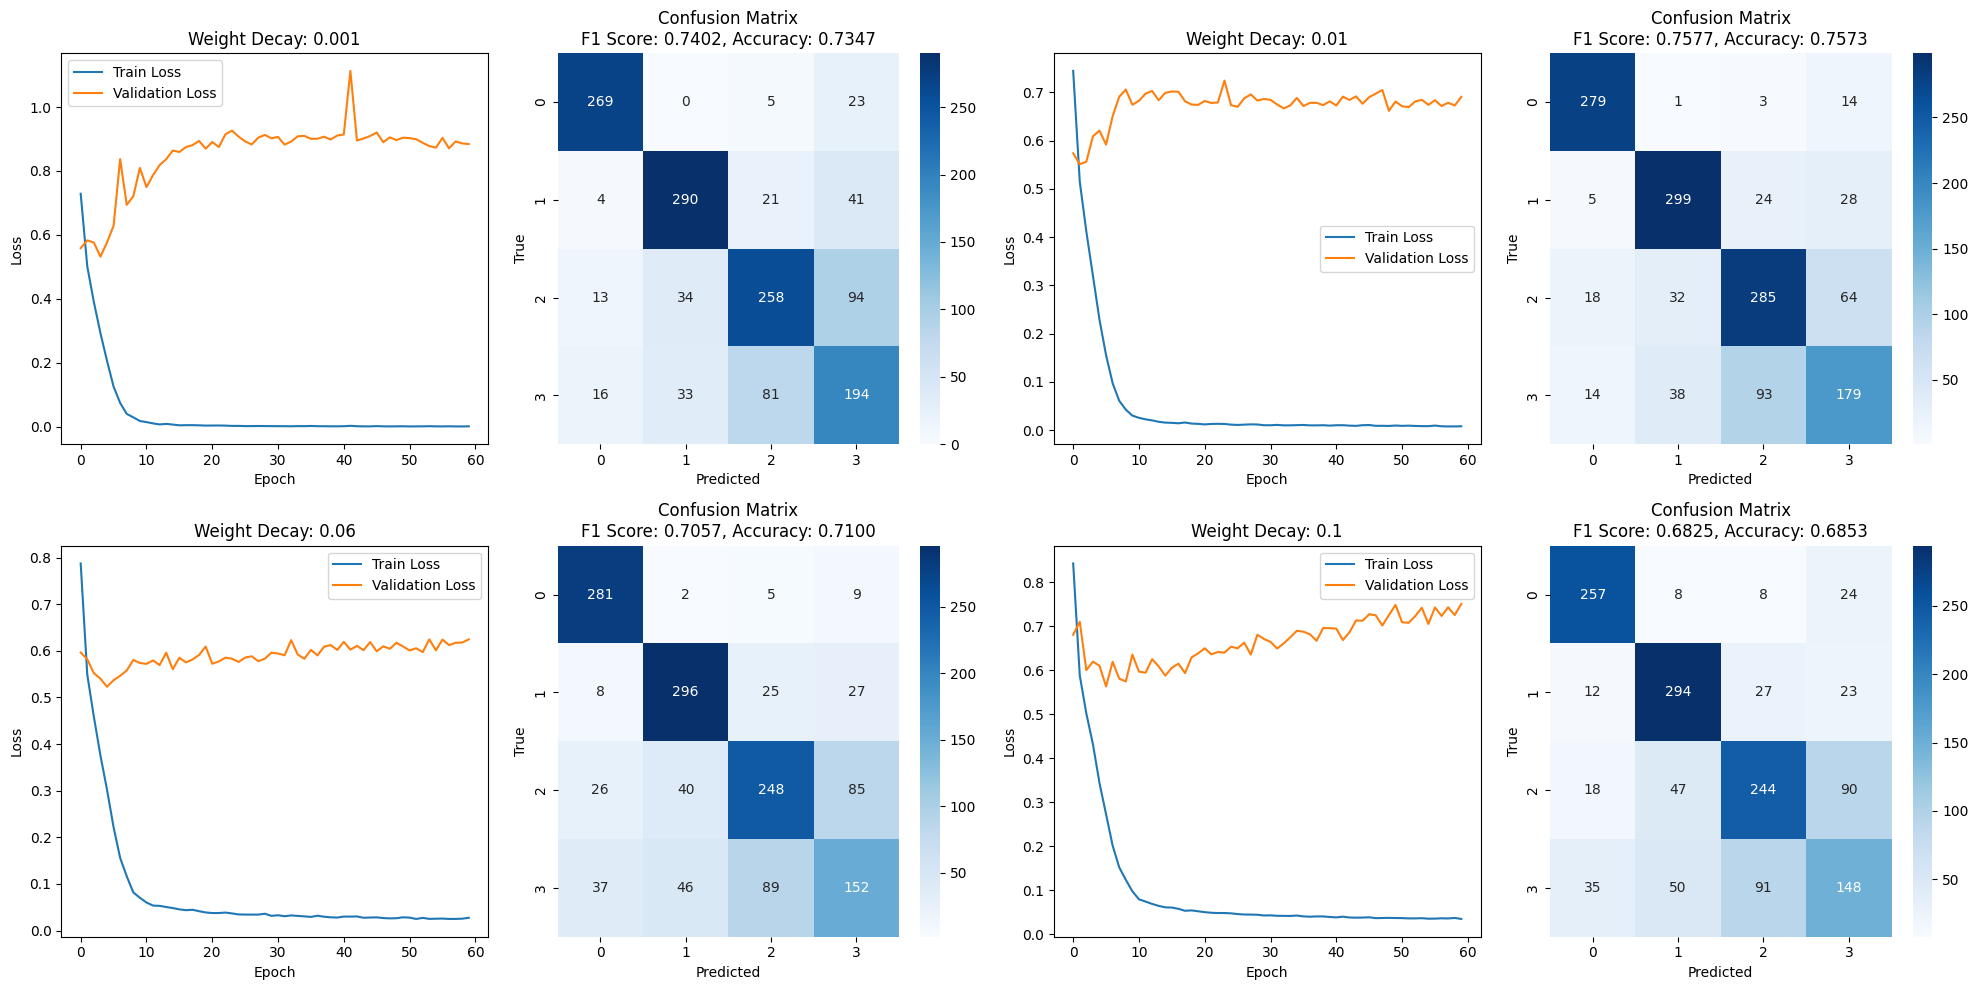

In [37]:
# Experiment 1: Varying weight decay with dropout = 0
weight_decay_values = [0.001, 0.01, 0.06, 0.1]
dropout = 0
num_plots = len(weight_decay_values)

fig = plt.figure(figsize=(20, 10))
grid = GridSpec(2, 4, figure=fig)
g = [(0, 0), (0, 2), (1, 0), (1, 2)]

for weight_decay in weight_decay_values:
    train_losses, val_losses, f1, accuracy, cm = experiment(weight_decay, dropout, train_dataloader, val_dataloader, test_dataloader, 'cuda')
    row, col = g.pop(0)
    # Plot the loss curves
    ax_loss = fig.add_subplot(grid[row, col])
    ax_loss.plot(train_losses, label='Train Loss')
    ax_loss.plot(val_losses, label='Validation Loss')
    ax_loss.set_title(f'Weight Decay: {weight_decay}')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Plot the confusion matrix
    ax_cm = fig.add_subplot(grid[row, col + 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix\nF1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('True')

plt.tight_layout()
plt.show()

In the following experiment for each dropout value we plot validation and train loss to see their difference. As we can see the value that minimizes the differnece of train and validation losses is 0.01.

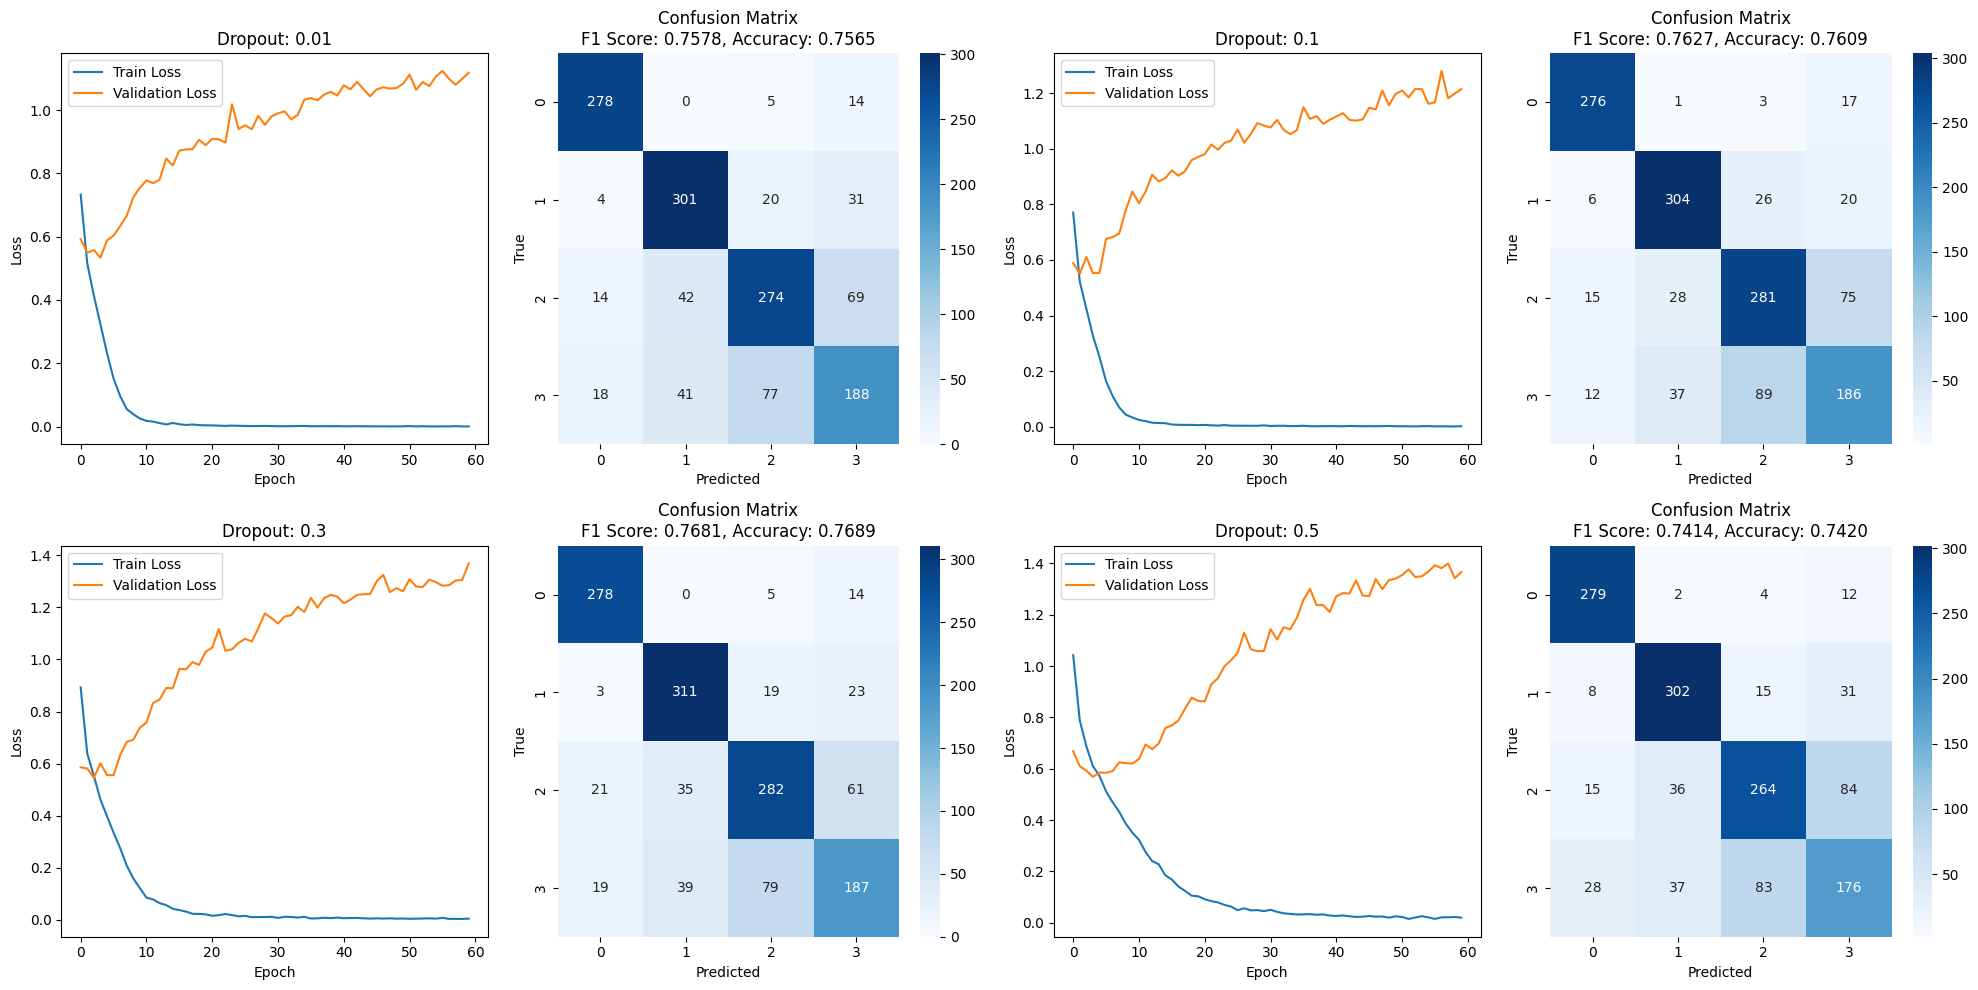

In [39]:
# Experiment 2: Varying dropout with weight decay = 0
dropout_values = [0.01, 0.1, 0.3, 0.5]
weight_decay = 0
num_plots = len(dropout_values)

fig = plt.figure(figsize=(20, 10))
grid = GridSpec(2, 4, figure=fig)
g = [(0, 0), (0, 2), (1, 0), (1, 2)]

for dropout in dropout_values:
    train_losses, val_losses, f1, accuracy, cm = experiment(weight_decay, dropout, train_dataloader, val_dataloader, test_dataloader, 'cuda')
    row, col = g.pop(0)
    # Plot the loss curves
    ax_loss = fig.add_subplot(grid[row, col])
    ax_loss.plot(train_losses, label='Train Loss')
    ax_loss.plot(val_losses, label='Validation Loss')
    ax_loss.set_title(f'Dropout: {dropout}')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Plot the confusion matrix
    ax_cm = fig.add_subplot(grid[row, col + 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix\nF1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('True')

plt.tight_layout()
plt.show()

Combining these two techniques we can observe that the differnce of train and validation losses is minimum when dropout = 0.01 and weight decay = 0.06

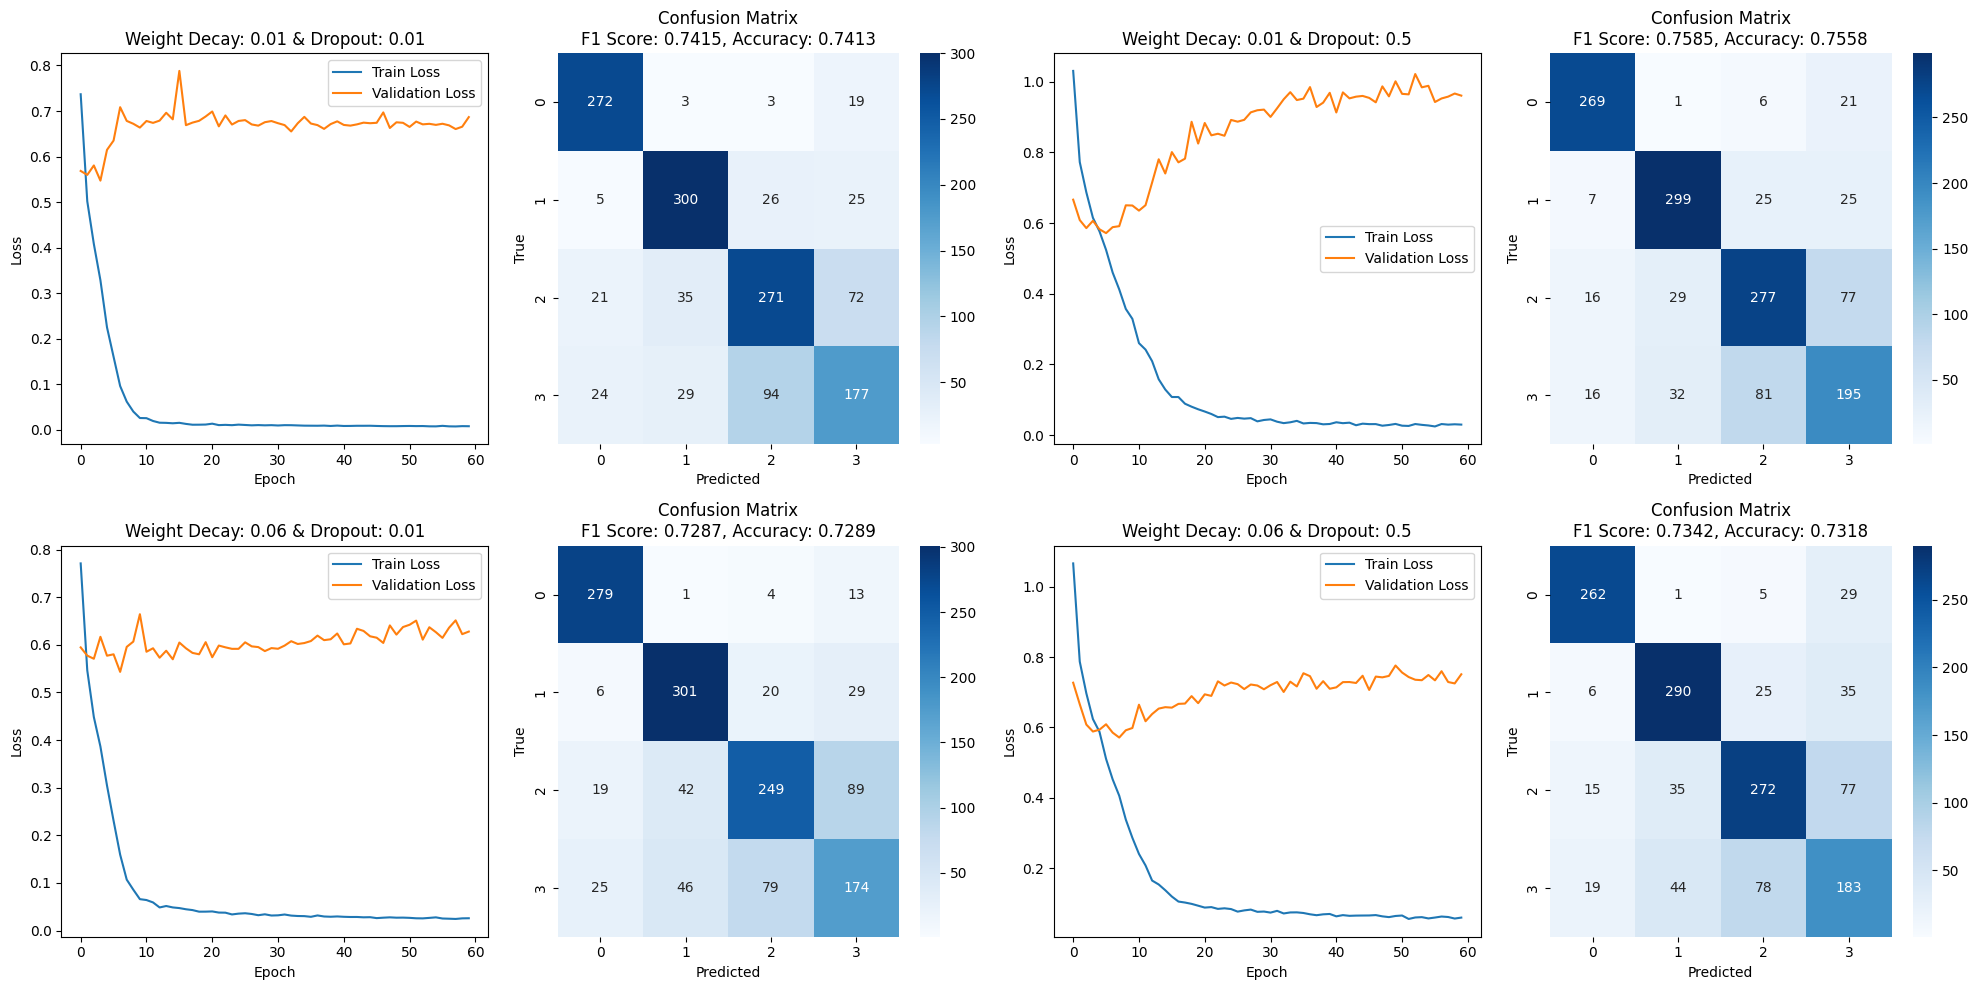

In [40]:
# Experiment 3: Varying weight decay and dropout
weight_decay_values =  [0.01, 0.01, 0.06, 0.06]
dropout_values = [0.01, 0.5, 0.01, 0.5]
num_plots = len(dropout_values)

# Plotting
fig = plt.figure(figsize=(20, 10))
grid = GridSpec(2, 4, figure=fig)
g = [(0, 0), (0, 2), (1, 0), (1, 2)]

for weight_decay, dropout in zip(weight_decay_values, dropout_values):
    train_losses, val_losses, f1, accuracy, cm = experiment(weight_decay, dropout, train_dataloader, val_dataloader, test_dataloader, 'cuda')
    row, col = g.pop(0)

    # Plot the loss curves
    ax_loss = fig.add_subplot(grid[row, col])
    ax_loss.plot(train_losses, label='Train Loss')
    ax_loss.plot(val_losses, label='Validation Loss')
    ax_loss.set_title(f'Weight Decay: {weight_decay} & Dropout: {dropout}')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Plot the confusion matrix
    ax_cm = fig.add_subplot(grid[row, col + 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix\nF1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('True')

plt.tight_layout()
plt.show()

## Exersice 4: Testing

Now, let's get rid of reproducibility and select the best model for weight decay = 0.06 and dropout = 0.01.

In [12]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# Melgrams data loading
train_dataset = MusicSignals('train', 'melgrams')
val_dataset = MusicSignals('val', 'melgrams')
test_dataset = MusicSignals('test', 'melgrams')

# Recreate data loaders without setting the seed for randomness
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Define and train the classifier

Loss: 0.7058270462128052
F1 macro averaged: 0.7617192438234436
Accuracy: 0.7587209302325582


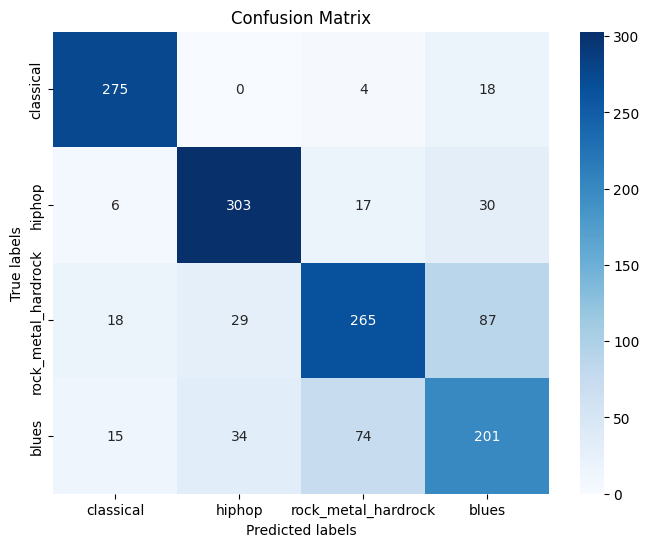

In [154]:
music_signal_classifier = ConvolutionalNeuralNetwork5((21, 128), 4, 0.01).to('cuda')
epochs = 60
optimizer = optim.Adagrad(music_signal_classifier.parameters(), lr=0.001, weight_decay=0.06)
criterion = nn.CrossEntropyLoss()

music_signal_classifier = select_model(music_signal_classifier, epochs, optimizer, train_dataloader, val_dataloader, criterion, 'cuda')
loss, f1, accuracy, cm = evaluate_network(music_signal_classifier, test_dataloader, criterion, 'cuda')

display_evaluation(loss, f1, accuracy, cm)

### Step 1: Inference

In [16]:
def inference(neural_network, X):
    predictions = []
    with torch.no_grad():
        neural_network.eval()
        outputs = neural_network(X)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
    return predictions

### Step 2: Download music from Youtube

In [17]:
# Step 1: Download the YouTube video as an audio file
def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    # Step 2: Convert the audio file to .wav format using pydub
    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    # Clean up the downloaded file
    os.remove(audio_file)

window_length = 50 * 1e-3
hop_length = 50 * 1e-3
mel_time_size = 22

def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None, fuse=False):
    """Returns a mel spectrogram."""
    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft, hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft, hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out

def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments

def youtube_to_melgram(url, name):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save(name, melgrams)

In [155]:
music_signal_classifier.to('cpu')

youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg', 'Nocturne.npy')
youtube_to_melgram('https://www.youtube.com/watch?v=YVkUvmDQ3HY', 'Without_Me.npy')
youtube_to_melgram('https://www.youtube.com/watch?v=tAGnKpE4NCI', 'Nothing_Else_Matters.npy')
youtube_to_melgram('https://www.youtube.com/watch?v=ioOzsi9aHQQ', 'Ill_Play_The_Blues_For_You.npy')

## Step 3: Predictions

Visualize predictions for each second of a song

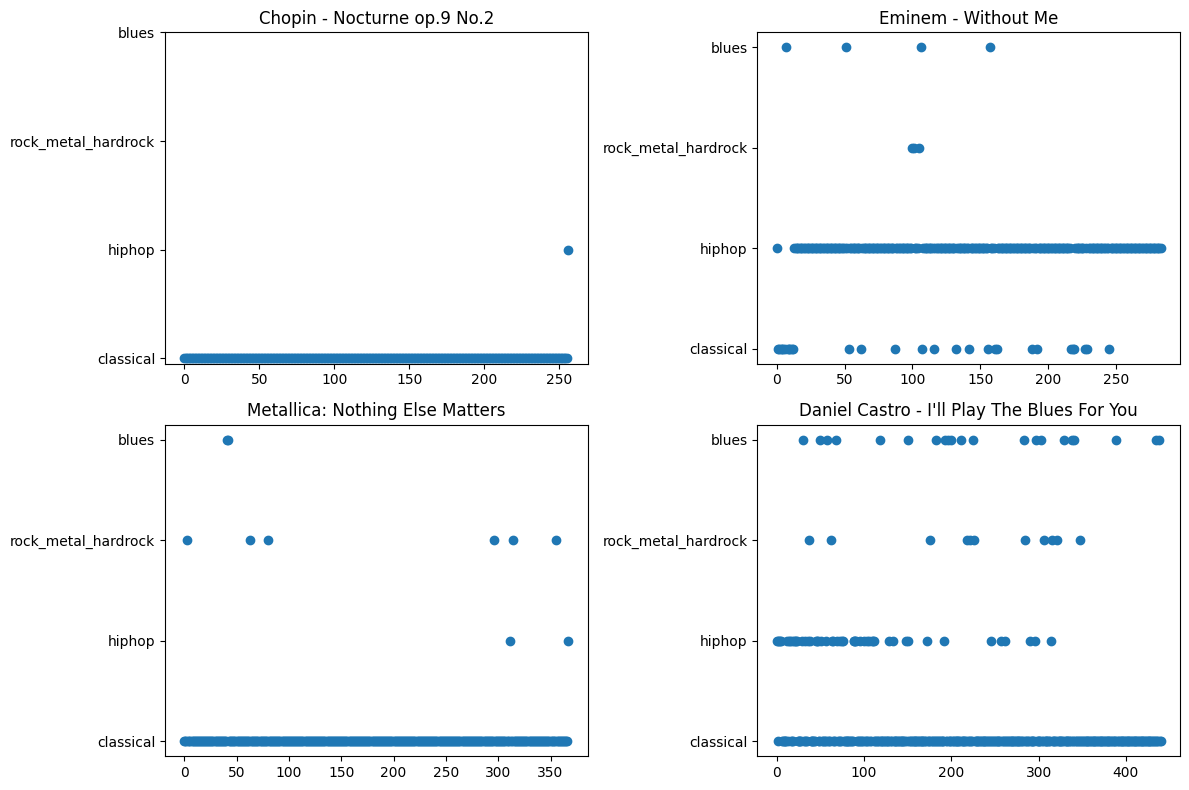

In [156]:
Nocturne = np.load('Nocturne.npy')
Without_Me = np.load('Without_Me.npy')
Nothing_Else_Matters = np.load('Nothing_Else_Matters.npy')
Ill_Play_The_Blues_For_You = np.load('Ill_Play_The_Blues_For_You.npy')

tensor1 = torch.tensor(Nocturne, dtype=torch.float32)
tensor2 = torch.tensor(Without_Me, dtype=torch.float32)
tensor3 = torch.tensor(Nothing_Else_Matters, dtype=torch.float32)
tensor4 = torch.tensor(Ill_Play_The_Blues_For_You, dtype=torch.float32)

pred1 = inference(music_signal_classifier, tensor1)
pred2 = inference(music_signal_classifier, tensor2)
pred3 = inference(music_signal_classifier, tensor3)
pred4 = inference(music_signal_classifier, tensor4)

# Define a figure and create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

genres = ['classical', 'hiphop', 'rock_metal_hardrock', 'blues']

# Plot each scatter plot in its corresponding subplot
axs[0, 0].scatter(range(len(Nocturne)), pred1)
axs[0, 0].set_title('Chopin - Nocturne op.9 No.2')
axs[0, 0].set_yticks([0, 1, 2, 3])
axs[0, 0].set_yticklabels(genres)

axs[0, 1].scatter(range(len(Without_Me)), pred2)
axs[0, 1].set_title('Eminem - Without Me')
axs[0, 1].set_yticks([0, 1, 2, 3])
axs[0, 1].set_yticklabels(genres)

axs[1, 0].scatter(range(len(Nothing_Else_Matters)), pred3)
axs[1, 0].set_title('Metallica: Nothing Else Matters')
axs[1, 0].set_yticks([0, 1, 2, 3])
axs[1, 0].set_yticklabels(genres)

axs[1, 1].scatter(range(len(Ill_Play_The_Blues_For_You)), pred4)
axs[1, 1].set_title("Daniel Castro - I'll Play The Blues For You")
axs[1, 1].set_yticks([0, 1, 2, 3])
axs[1, 1].set_yticklabels(genres)

plt.tight_layout()
plt.show()

In [157]:
def predicted(pred, num):
    return len([a for a in pred if a == num])

print(f"Chopin - Nocturne op.9 No.2: {predicted(pred1, 0)}/{len(pred1)}")
print(f"Eminem - Without Me: {predicted(pred2, 1)}/{len(pred2)}")
print(f"Metallica - Nothing Else Matters: {predicted(pred3, 2)}/{len(pred3)}")
print(f"Daniel Castro - I'll Play The Blues For You: {predicted(pred4, 3)}/{len(pred4)}")

Chopin - Nocturne op.9 No.2: 256/257
Eminem - Without Me: 248/284
Metallica - Nothing Else Matters: 6/368
Daniel Castro - I'll Play The Blues For You: 21/441


In [158]:
def majority_voting(pred):
    classical = (predicted(pred, 0), 'classical')
    hiphop = (predicted(pred, 1), 'hiphop')
    rock_metal_hardrock = (predicted(pred, 2), 'rock_metal_hardrock')
    blues = (predicted(pred, 3), 'blues')

    return max([classical, hiphop, rock_metal_hardrock, blues], key = lambda x:x[0])

print(f"Chopin - Nocturne op.9 No.2: {majority_voting(pred1)[1]}")
print(f"Eminem - Without Me: {majority_voting(pred2)[1]}")
print(f"Metallica - Nothing Else Matters: {majority_voting(pred3)[1]}")
print(f"Daniel Castro - I'll Play The Blues For You: {majority_voting(pred4)[1]}")

Chopin - Nocturne op.9 No.2: classical
Eminem - Without Me: hiphop
Metallica - Nothing Else Matters: classical
Daniel Castro - I'll Play The Blues For You: classical


As we can see, the model (using majority voting) predicts 2 of the songs correctly, with minor errors, whereas the other 2 are being classified wrongly.

We can also, see the total accuracy of all the one second signals of the 4 songs as follows:

In [96]:
correct = predicted(pred1, 0) + predicted(pred2, 1) + predicted(pred3, 2) + predicted(pred1, 0)
total = len(pred1) + len(pred2) + len(pred3) + len(pred4)
print(f"Total Accuracy: {correct/total}")

Total Accuracy: 0.5059259259259259


The accuracy of predicting in the test set is 75%, whereas for YouTube songs it is 50%.






